In [14]:
from azureml.core import Workspace, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from math import sqrt
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
from scipy.stats import skew 

In [20]:
from azureml.core import Workspace, Dataset
subscription_id = '8e299c88-fef2-4853-9d1c-6183a693faf5'
resource_group = 'rg-rav-dev-emea-ai-data'
workspace_name = 'ml-rav-dev-emea-ai-data'
pd.set_option('display.max_columns', None)
workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='project_rene')
data = dataset.to_pandas_dataframe()
data.head()
SecureData = data.drop(columns=['CUSTOMER_NAME', 'PRODUCT_DESCRIPTION', 'PROVINCE_STATE'], axis=1)
SecureData.to_csv('/home/azureuser/cloudfiles/code/Users/adm_ReneZb/data.csv')
SecureData.head()


{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


ORDER_LINE_NUMBER ORDER_LINE_STATUS  ORDER_LINE_STATUS_ID  \
0        6835481-01               INV                   150   
1        2845148-01               INV                   150   
2        2599061-01               INV                   150   
3        1486418-01               INV                   150   
4        4831570-01               INV                   150   

  ORDER_LINE_OPEN_STATUS  PRICE_FIXED  CUSTOMER_ID CUSTOMER_SEGMENT  \
0                 Closed         True       635674                A   
1                 Closed         True       502429                C   
2                 Closed         True        50832                C   
3                 Closed         True        50245                C   
4                 Closed         True       503557                C   

   PRODUCT_ID OLE_CURRENCY  QUANTITY_SI QUANTITY_US  YEAR  MONTH       DATE  \
0       13935          EUR       4125.0   9094,0683  2019     11 2019-11-22   
1       22288          EUR       1375.0   3031,3561  2014      4 2014-04-03   
2       13935          EUR      25420.0   56041,507  2013      8 2013-08-14   
3       13935          EUR       6375.0  14054,4692  2010      5 2010-05-14   
4       22288          EUR       4125.0   9094,0683  2017      4 2017-04-27   

   OLE_ID  COUNTRY_ID SI_UOM US_UOM   REVENUE COST_PRICE GM1_PROFIT  \
0     373          55     kg     lb    5362,5    4743,75     618,75   
1     373          55     kg     lb      2750    2433,75     316,25   
2     373          55     kg     lb   35333,8    33554,4     1779,4   
3     373          55     kg     lb      9435     8032,5     1402,5   
4     373          55     kg     lb  8105,625       7590    515,625   

       GM2_PROFIT  
0  595,2546364875  
1         133,375  
2   955,400000722  
3   1303,33333305  
4  324,7249999125

In [6]:
#DATA CLEANING
removedUSQuantityAndMetrics = data.drop(columns=['SI_UOM', 'US_UOM', 'QUANTITY_US', 'ORDER_LINE_NUMBER', 'ORDER_LINE_STATUS', 'ORDER_LINE_STATUS_ID', 
'ORDER_LINE_OPEN_STATUS', 'PRICE_FIXED', 'OLE_CURRENCY'], axis=1)
removedUSQuantityAndMetrics.head()
#removedUSQuantityAndMetrics = removedUSQuantityAndMetrics[removedUSQuantityAndMetrics["MONTH"]>2]
removedUSQuantityAndMetrics['DATE'] = pd.to_datetime(removedUSQuantityAndMetrics['DATE'], errors='coerce')
removedUSQuantityAndMetrics = removedUSQuantityAndMetrics.sort_values(by='DATE', ascending=True, inplace=False)
#removedUSQuantityAndMetrics.sort_values(by='DATE', ascending=True, inplace=False)
#removedUSQuantityAndMetrics.sort_values(by='MONTH', ascending=True, inplace=False).head(10)
removedDate = removedUSQuantityAndMetrics.drop('DATE', axis = 1)
#removedDate.head()
removedProvinceAndOleID = removedDate.drop(columns=['OLE_ID', 'PROVINCE_STATE', 'MONTH'])
removedProvinceAndOleID.head()
dataforPlot = removedProvinceAndOleID
#REPLACING To float value
dataforPlot['REVENUE'] = dataforPlot['REVENUE'].str.replace(',','.').astype('float')
dataforPlot['COST_PRICE'] = dataforPlot['COST_PRICE'].str.replace(',','.').astype('float')
dataforPlot['GM1_PROFIT'] = dataforPlot['GM1_PROFIT'].str.replace(',','.').astype('float')
dataforPlot['GM2_PROFIT'] = dataforPlot['GM2_PROFIT'].str.replace(',','.').astype('float')
dataforPlot = dataforPlot[dataforPlot["YEAR"]<2025]
dataforPlot = dataforPlot[dataforPlot["YEAR"]>2020]
#dataforPlot = dataforPlot[dataforPlot["YEAR"]>=2024]
dataforPlot = dataforPlot[dataforPlot["QUANTITY_SI"]>0]
dataforPlot = dataforPlot[dataforPlot["COST_PRICE"] != 0]
print(dataforPlot)

       CUSTOMER_ID                 CUSTOMER_NAME CUSTOMER_SEGMENT  PRODUCT_ID  \
3680        200554                 M&G Group B.V                A       13935   
12448        50517            Reimer & Grau GmbH                A       22288   
15378        50517            Reimer & Grau GmbH                A       22745   
43250       508113            PLASTICS IDE, S.A.                C       22745   
24662       634623                Bray Group Ltd                C       22473   
...            ...                           ...              ...         ...   
42914       507231    VIGNATI PIETRO & LUIGI SRL                B       22473   
20158       510510  Simon Kunststofftechnik GmbH                A       22288   
45842       542376       GIUDICI ENRICO & C. snc                C       22288   
41487        18672            BISIO PROGETTI SPA                A       22473   
51161       542376       GIUDICI ENRICO & C. snc                C       22473   

              PRODUCT_DESCR

22473     3333
22288     2631
13935     1815
22745     1108
23161      910
13904      570
23094      504
152234     273
2945       253
Name: PRODUCT_ID, dtype: int64


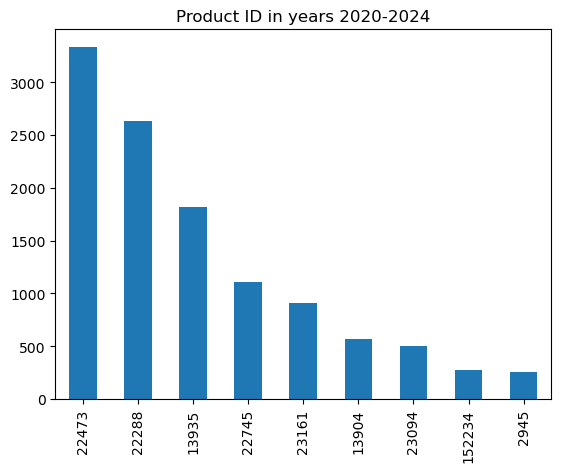

In [7]:
values = dataforPlot['PRODUCT_ID'].value_counts()
dataforPlot['PRODUCT_ID'].value_counts().plot(kind='bar', title="Product ID in years 2020-2024")
dataforPlot['PRODUCT_ID'].value_counts().describe()
print(values)
#dataforPlot['YEAR'].value_counts().sort_index().plot(kind='bar')
#dataforPlot['REVENUE'].plot(kind='box')
#dataforPlot.boxplot(column = ['QUANTITY_SI'])

A    5229
C    4913
B    1174
Name: CUSTOMER_SEGMENT, dtype: int64


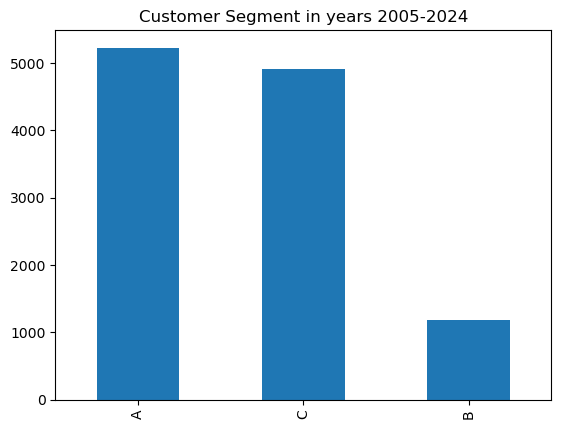

In [8]:
#CUSTOMER SEGMENT
values = dataforPlot['CUSTOMER_SEGMENT'].value_counts()
dataforPlot['CUSTOMER_SEGMENT'].value_counts().plot(kind='bar', title="Customer Segment in years 2005-2024")
dataforPlot['CUSTOMER_SEGMENT'].value_counts().describe()
print(values)

In [9]:
#SKEWNESS OF PRODUCTS
eachProduct = dataforPlot['PRODUCT_ID'].value_counts()
eachProductSummary = eachProduct.describe()
onlyProductAndGrossMargin2 = dataforPlot[["PRODUCT_ID", 'GM2_PROFIT']]
group = onlyProductAndGrossMargin2.groupby("PRODUCT_ID")
skewness_per_product = group.apply(lambda x: skew(x['GM2_PROFIT'], bias=True))
#skew(onlyProductAndGrossMargin2, axis=0, bias=True)
skewness_per_product

PRODUCT_ID
2945      2.827227
13904     6.192797
13935     2.545036
22288     5.441573
22473     3.966564
22745    -2.444888
23094     2.703827
23161     5.813971
152234    4.478994
dtype: float64

In [10]:
#SKEWNESS OF CUSTOMER COLUMN
customerSkewness = dataforPlot['CUSTOMER_ID'].value_counts()
skewness_matrix = customerSkewness.skew()
print(f'The skewness of the customer id column is:  {skewness_matrix}')
print(customerSkewness.head(5))


The skewness of the customer id column is:  6.201956879582661
16138     207
514598    179
526381    114
563410    110
503797     89
Name: CUSTOMER_ID, dtype: int64


In [11]:
productSkewness = dataforPlot['PRODUCT_ID'].value_counts()
skewness_matrix = productSkewness.skew()
print(f'The skewness of the product id column is:  {skewness_matrix}')
print(productSkewness.head(5))

The skewness of the product id column is:  1.050712146005157
22473    3333
22288    2631
13935    1815
22745    1108
23161     910
Name: PRODUCT_ID, dtype: int64


In [12]:
#SKEWNESS OF QUANTITY BREAK COLUMN
customerSkewness = dataforPlot['CUSTOMER_ID'].value_counts()
skewness_matrix = customerSkewness.skew()
print(f'The skewness of the customer id column is:  {skewness_matrix}')
print(customerSkewness.head(5))

The skewness of the customer id column is:  6.201956879582661
16138     207
514598    179
526381    114
563410    110
503797     89
Name: CUSTOMER_ID, dtype: int64


In [13]:
#FEATURE ENGINEERING
#creating gm2 in percentage from gm2 profit and cost price columns
dataforPlot['GM2Percentage'] = ((dataforPlot["GM2_PROFIT"] / (dataforPlot["COST_PRICE"]))*100).round(2)
#DO NOT FORGET THIS PART OF REMOVING TO EXPLAIN
dataforPlot = dataforPlot[abs(dataforPlot["GM2Percentage"]) < 2000]
dataforPlot = dataforPlot[(dataforPlot["GM2Percentage"]) > 0]
#dataforPlot['GM2Percentage'].value_counts().plot(kind='bar')
dataNewFeatureAndRemoval = dataforPlot.drop(columns=['GM2_PROFIT', "GM1_PROFIT",
'COST_PRICE', 'REVENUE'], axis=1)
dataNewFeatureAndRemoval.head(5)

CUSTOMER_ID       CUSTOMER_NAME CUSTOMER_SEGMENT  PRODUCT_ID  \
3680        200554       M&G Group B.V                A       13935   
12448        50517  Reimer & Grau GmbH                A       22288   
15378        50517  Reimer & Grau GmbH                A       22745   
43250       508113  PLASTICS IDE, S.A.                C       22745   
24662       634623      Bray Group Ltd                C       22473   

              PRODUCT_DESCRIPTION  QUANTITY_SI  YEAR  COUNTRY_ID  \
3680      Moplen EP 540 P NATURAL      13750.0  2021         160   
12448      Terluran GP 22 NATURAL       2750.0  2021          55   
15378  Terluran GP 22 BLACK 10009       2750.0  2021          55   
43250  Terluran GP 22 BLACK 10009        300.0  2021          66   
24662      Terluran GP 35 NATURAL       1375.0  2021          76   

       GM2Percentage  
3680           28.03  
12448           2.56  
15378          33.52  
43250          33.10  
24662          37.64

   CUSTOMER_ID  total_sales
0          554            2
1          557           10
2          577            5
3          674            4
4         1585            9
      CUSTOMER_ID  total_sales
88          16138          203
706        514598          158
858        526381          111
1031       563410          101
375        200554           88
463        503797           84
681        512026           84
1000       554086           82
1247       704101           67
294         51123           63
91          16152           62
27           4704           58
385        200836           57
40          13201           57
1159       656464           57
1300       737015           54
697        513316           54
93          16466           49
674        511510           49
1142       650473           48
      CUSTOMER_ID  total_sales  log_transformed sales_class
0             554            2         0.693147      Medium
1             557           10         2.302585        High
2

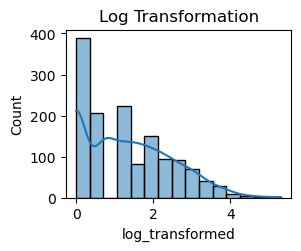

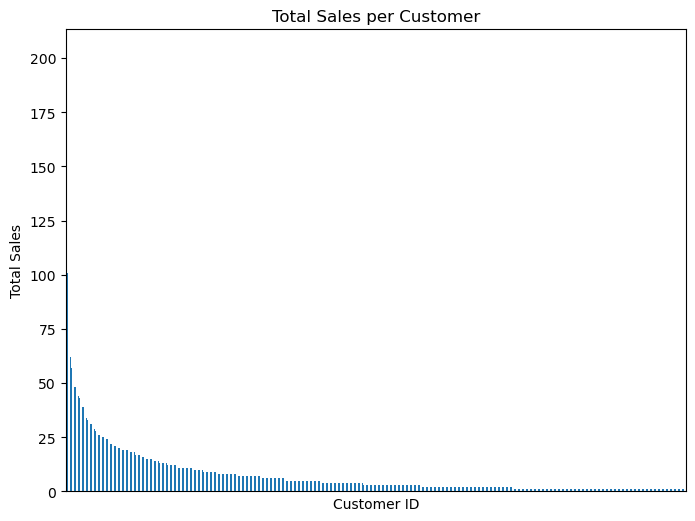

   CUSTOMER_ID       CUSTOMER_NAME CUSTOMER_SEGMENT  PRODUCT_ID  \
0       200554       M&G Group B.V                A       13935   
1        50517  Reimer & Grau GmbH                A       22288   
2        50517  Reimer & Grau GmbH                A       22745   
3       508113  PLASTICS IDE, S.A.                C       22745   
4       634623      Bray Group Ltd                C       22473   

          PRODUCT_DESCRIPTION  QUANTITY_SI  YEAR  COUNTRY_ID  GM2Percentage  \
0     Moplen EP 540 P NATURAL      13750.0  2021         160          28.03   
1      Terluran GP 22 NATURAL       2750.0  2021          55           2.56   
2  Terluran GP 22 BLACK 10009       2750.0  2021          55          33.52   
3  Terluran GP 22 BLACK 10009        300.0  2021          66          33.10   
4      Terluran GP 35 NATURAL       1375.0  2021          76          37.64   

  sales_class  
0        High  
1        High  
2        High  
3      Medium  
4        High  


In [14]:
# Assuming dataNewFeatureAndRemoval is your DataFrame
sales_per_customer = dataNewFeatureAndRemoval.groupby('CUSTOMER_ID').size().reset_index(name='total_sales')
sales_per_customer_sorted = sales_per_customer.sort_values(by='total_sales', ascending=False)
print(sales_per_customer.head(5))
#skewness_per_customer = sales_per_customer.apply(lambda x: skew(x['CUSTOMER_ID'], bias=True))
#print(skewness_per_product)
# Display the first 5 entries
print(sales_per_customer_sorted.head(20))
sales_per_customer['log_transformed'] = np.log(sales_per_customer['total_sales'])
plt.subplot(2, 2, 2)
sns.histplot(sales_per_customer['log_transformed'], kde=True)
plt.title('Log Transformation')
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = sales_per_customer['log_transformed'].quantile(0.25)
Q3 = sales_per_customer['log_transformed'].quantile(0.75)
# Calculate the IQR
IQR = Q3 - Q1
# Display the results
def classify_sales(value):
    if value <= Q1:
        return 'Low'
    elif Q1 < value <= Q3:
        return 'Medium'
    else:
        return 'High'


# Step 3: Apply classification
sales_per_customer['sales_class'] = sales_per_customer['log_transformed'].apply(classify_sales)

print(sales_per_customer)
low_count = sales_per_customer['sales_class'].value_counts().get('Low', 0)

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR (Interquartile Range): {IQR}")
# Print the count of "Low" sales class
print(f"Number of customers with 'Low' sales class: {low_count}")
# Plot the total sales per customer
plt.figure(figsize=(8, 6))
#plt.bar(sales_per_customer['CUSTOMER_ID'], sales_per_customer['sales_class'], color=plt.cm.viridis(np.linspace(0, 1, len(sales_per_customer['CUSTOMER_ID']))))
#plt.bar(sales_per_customer['total_sales'])
#sales_per_customer['total_sales'].plot(kind='bar')
sales_per_customer_sorted['total_sales'].plot(kind='bar')
plt.title('Total Sales per Customer')
plt.xlabel('Customer ID')
plt.ylabel('Total Sales')

# Adjust the y-axis limits to zoom in (modify the range as needed)
#plt.ylim(0, 100)
plt.xticks([])
plt.show()

dataNewFeatureAndRemoval = pd.merge(dataNewFeatureAndRemoval, sales_per_customer[['CUSTOMER_ID', 'sales_class']], on='CUSTOMER_ID', how='left')
print(dataNewFeatureAndRemoval.head(5))

In [15]:
#Data binning
#inserting quantities in quantity breaks
bins = [0, 100, 500, 1375, 2750, 4125, 5500, 6875, 8250, 9625, 11000,
 12375, 13750, 15125, 16500, 17500, 30000]
labels = [
    '0-100', '101-500', '501-1375', '1376-2750', '2751-4125', '4126-5500',
    '5501-6875', '6876-8250', '8251-9625', 
    '9626-11000', '11001-12375', '12376-13750', '13751-15125', '15126-16500',
     '16501-17500', '17501-30000'
]
dataNewFeatureAndRemoval['Quantity_Break'] = pd.cut(dataNewFeatureAndRemoval['QUANTITY_SI'],
 bins=bins, labels=labels, right=True)
dataAllDone = dataNewFeatureAndRemoval.drop('QUANTITY_SI', axis=1)
dataAllDone.head(5)

CUSTOMER_ID       CUSTOMER_NAME CUSTOMER_SEGMENT  PRODUCT_ID  \
0       200554       M&G Group B.V                A       13935   
1        50517  Reimer & Grau GmbH                A       22288   
2        50517  Reimer & Grau GmbH                A       22745   
3       508113  PLASTICS IDE, S.A.                C       22745   
4       634623      Bray Group Ltd                C       22473   

          PRODUCT_DESCRIPTION  YEAR  COUNTRY_ID  GM2Percentage sales_class  \
0     Moplen EP 540 P NATURAL  2021         160          28.03        High   
1      Terluran GP 22 NATURAL  2021          55           2.56        High   
2  Terluran GP 22 BLACK 10009  2021          55          33.52        High   
3  Terluran GP 22 BLACK 10009  2021          66          33.10      Medium   
4      Terluran GP 35 NATURAL  2021          76          37.64        High   

  Quantity_Break  
0    12376-13750  
1      1376-2750  
2      1376-2750  
3        101-500  
4       501-1375

In [16]:
#dataAllDone["PRICE_FIXED"].value_counts()
#dataAllDone["ORDER_LINE_OPEN_STATUS"].describe()]
#dataAllDone["ORDER_LINE_STATUS"].value_counts()
dataAllDone["CUSTOMER_ID"].value_counts()
#dataAllDone = dataAllDone.drop(columns=['PRICE_FIXED', 'ORDER_LINE_STATUS', 'ORDER_LINE_OPEN_STATUS', 'ORDER_LINE_NUMBER', 'ORDER_LINE_STATUS_ID', 'OLE_CURRENCY'], axis=1)
#dataAllDone = dataAllDone.drop(columns=['CUSTOMER_NAME', 'PRODUCT_DESCRIPTION', 'YEAR', 'MONTH'])
dataAllDone = dataAllDone.drop(columns=['CUSTOMER_NAME', 'PRODUCT_DESCRIPTION'])
le = LabelEncoder()
dataAllDone["CUSTOMER_SEGMENT"] =le.fit_transform(dataAllDone["CUSTOMER_SEGMENT"])
dataAllDone["Quantity_Break"] =le.fit_transform(dataAllDone["Quantity_Break"])
dataAllDone["YEAR"] = le.fit_transform(dataAllDone["YEAR"])
dataAllDone["sales_class"] = le.fit_transform(dataAllDone["sales_class"])
#dataAllDone = dataAllDone.drop(columns=['YEAR'])
#print(dataAllDone.head(5))
numberOfCustomers = dataAllDone["CUSTOMER_ID"].nunique()
numberOfQuantityBreaks = dataAllDone["Quantity_Break"].nunique()
numberOfCustomerSegments = dataAllDone["CUSTOMER_SEGMENT"].nunique()
numberOfCountries = dataAllDone["COUNTRY_ID"].nunique()
print(f'Number of Customers: {numberOfCustomers}')
print(f"Number of Quantity Breaks: {numberOfQuantityBreaks}")
print(f"Number of Customer Segments: {numberOfCustomerSegments}")
print(f"Number of Countries: {numberOfCountries}")

Number of Customers: 1395
Number of Quantity Breaks: 16
Number of Customer Segments: 4
Number of Countries: 17


The skewness of the Quantity break column is:  2.237503691815281
The summary of the Quantity break column is: count      16.000000
mean      657.937500
std       909.333417
min         2.000000
25%       139.000000
50%       204.000000
75%       816.250000
max      3451.000000
Name: Quantity_Break, dtype: float64


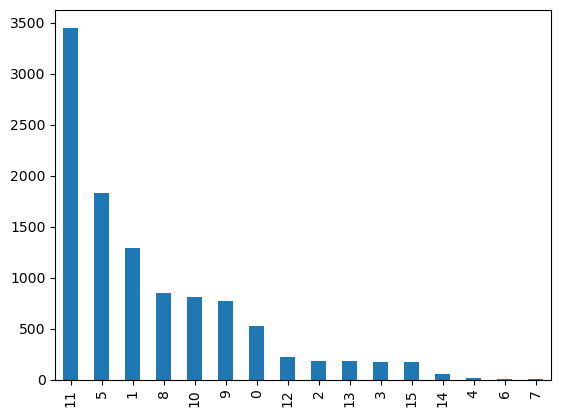

In [17]:
#SKEWNESS OF QUANTITY BREAK COLUMN
customerSkewness = dataAllDone['Quantity_Break'].value_counts()
customerSkewnessSummary = dataAllDone['Quantity_Break'].value_counts().describe()
customerSkewnessPlot = dataAllDone['Quantity_Break'].value_counts().plot(kind='bar')
skewness_matrix = customerSkewness.skew()
print(f'The skewness of the Quantity break column is:  {skewness_matrix}')
print(f'The summary of the Quantity break column is: {customerSkewnessSummary}')

The skewness of the Quantity break column is:  1.029518762940495
The summary of the Quantity break column is: count       3.000000
mean     3509.000000
std      3643.705669
min       390.000000
25%      1506.500000
50%      2623.000000
75%      5068.500000
max      7514.000000
Name: sales_class, dtype: float64


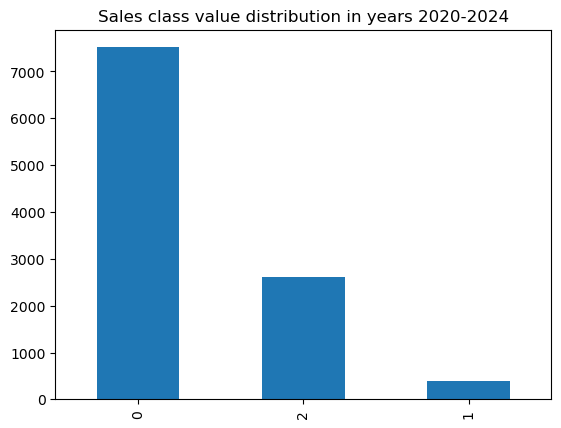

In [18]:
#SKEWNESS OF Sales_class COLUMN
salesClassSkewness = dataAllDone['sales_class'].value_counts()
customerSkewnessSummary = dataAllDone['sales_class'].value_counts().describe()
customerSkewnessPlot = dataAllDone['sales_class'].value_counts().plot(kind='bar', title= 'Sales class value distribution in years 2020-2024')
skewness_matrix = salesClassSkewness.skew()
print(f'The skewness of the Quantity break column is:  {skewness_matrix}')
print(f'The summary of the Quantity break column is: {customerSkewnessSummary}')

                  Skewness
CUSTOMER_ID      -2.989598
CUSTOMER_SEGMENT  0.000000
YEAR              0.000000
COUNTRY_ID        0.253807
GM2Percentage     1.540952
sales_class       0.000000
Quantity_Break    0.215970


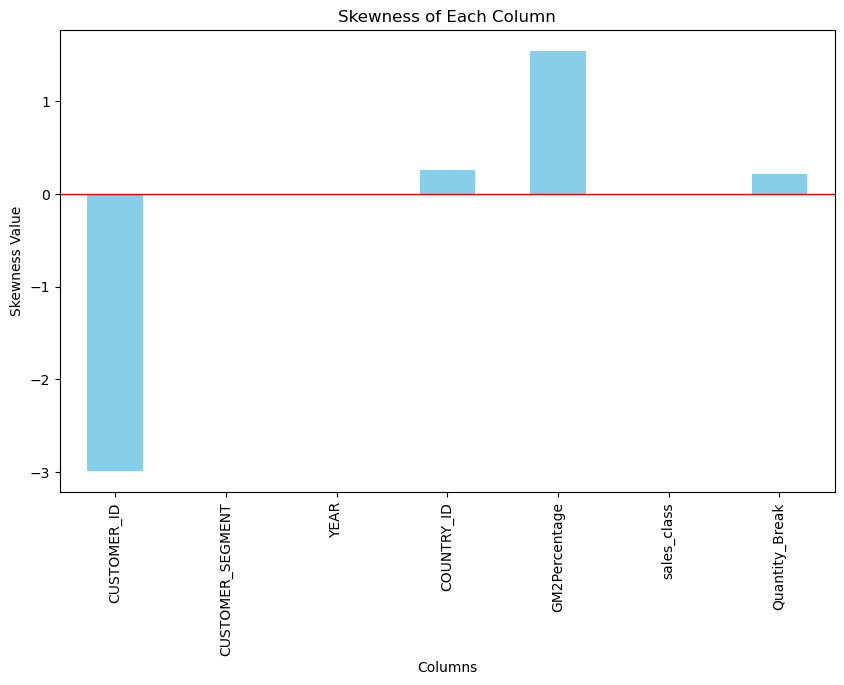

In [19]:
grouped = dataAllDone.groupby('PRODUCT_ID').median()
skewness_matrix = grouped.skew()

# If you want to convert it into a DataFrame (matrix form)
skewness_matrix_df = skewness_matrix.to_frame(name='Skewness')

# Displaying the skewness matrix
print(skewness_matrix_df)
# Plotting the skewness matrix as a bar plot
plt.figure(figsize=(10, 6))
skewness_matrix.plot(kind='bar', color='skyblue')  # You can customize the color if needed
plt.title('Skewness of Each Column')
plt.xlabel('Columns')
plt.ylabel('Skewness Value')
plt.axhline(0, color='red', linewidth=1)  # Add a horizontal line at y=0 for reference
plt.show()

[107, 55, 76, 73, 174, 160, 66, 190, 41, 57]


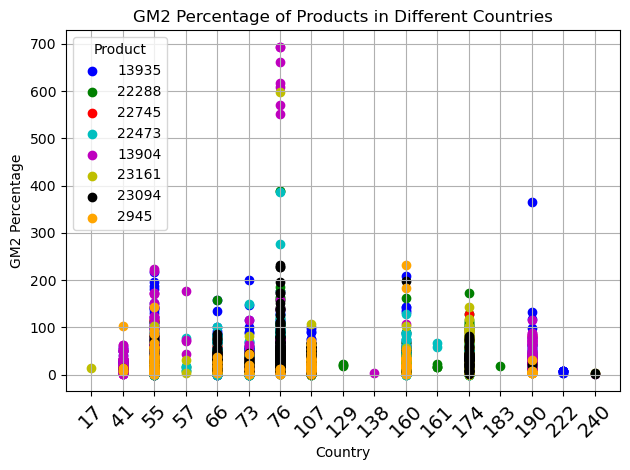

In [20]:
#Plotting each product's gross margin profit percentage in each country
products = dataAllDone['PRODUCT_ID'].unique()
countriesWithMostValues = dataAllDone['COUNTRY_ID'].value_counts().nlargest(10).index.tolist()
print(countriesWithMostValues)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']  # Different colors for different products
country_mapping = {country: i for i, country in enumerate(sorted(dataAllDone['COUNTRY_ID'].unique()))}
dataAllDonePlot = dataAllDone
dataAllDonePlot['Country_Pos'] = dataAllDone['COUNTRY_ID'].map(country_mapping)
for product, color in zip(products, colors):
    subset = dataAllDonePlot[dataAllDonePlot['PRODUCT_ID'] == product]
    plt.scatter(subset['Country_Pos'], subset['GM2Percentage'], marker='o', linestyle='-', color=color, label=product)

all_countries = dataAllDonePlot['COUNTRY_ID'].unique()
labels = [country if country in countriesWithMostValues else '' for country in all_countries]
plt.xticks(range(len(country_mapping)), labels=list(country_mapping.keys()), rotation=45, fontsize=14)
#plt.xticks(all_countries, labels=labels, rotation=90, fontsize=10, ha='right')

#plt.xticks(dataAllDone['COUNTRY_ID'].unique(), ha='right')
plt.title('GM2 Percentage of Products in Different Countries')
plt.xlabel('Country')
plt.ylabel('GM2 Percentage')
plt.legend(title='Product')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
#checkingforSkewness
onlyProductAndGrossMargin2 = dataforPlot[["PRODUCT_ID", 'GM2Percentage']]
groupByProductID = onlyProductAndGrossMargin2.groupby("PRODUCT_ID")
print(groupByProductID)
skewness_per_product = groupByProductID.apply(lambda x: skew(x['GM2Percentage'], bias=True))
#skew(onlyProductAndGrossMargin2, axis=0, bias=True)
skewness_per_product
#for product_id, group in groupByProductID:
#    plt.figure()
#    group.plot(kind='bar', x='PRODUCT_ID', y='GM2Percentage', legend=False)
#    plt.title(f'Product ID: {product_id}')
#    plt.xlabel('Index')
#    plt.ylabel('GM2Percentage')
#    plt.show()

PRODUCT_ID
2945       4.360915
13904      6.706090
13935      3.511865
22288      6.678294
22473      5.153775
22745      2.629679
23094      2.723477
23161     11.698484
152234     1.519660
dtype: float64

                          GM2Percentage
PRODUCT_ID                             
2945       GM2Percentage            1.0
13904      GM2Percentage            1.0
13935      GM2Percentage            1.0
22288      GM2Percentage            1.0
22473      GM2Percentage            1.0
22745      GM2Percentage            1.0
23094      GM2Percentage            1.0
23161      GM2Percentage            1.0
152234     GM2Percentage            1.0


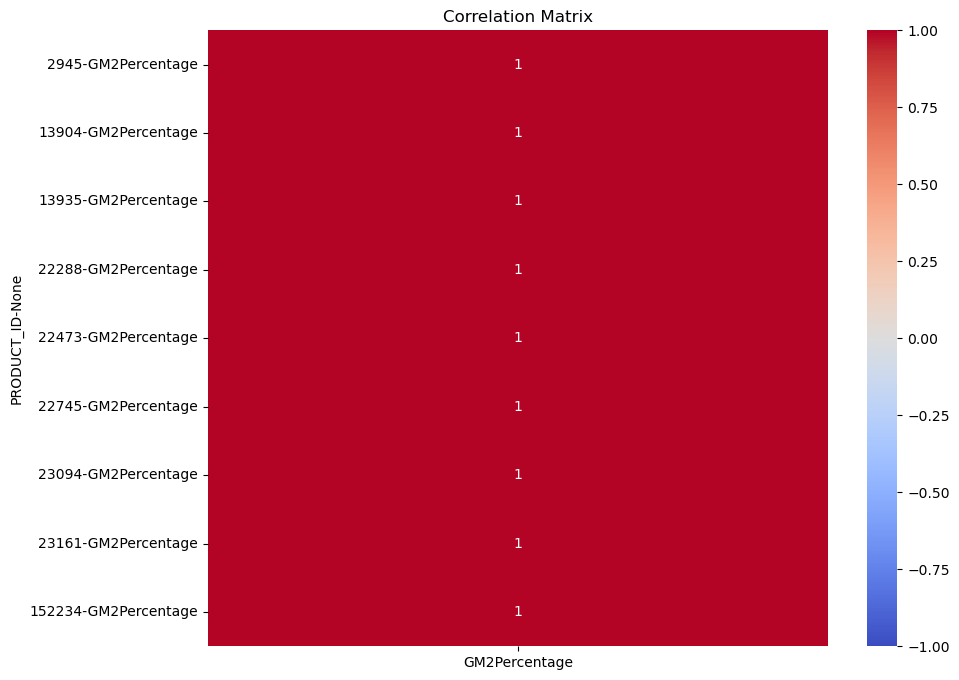

In [22]:
dataCorrelations = groupByProductID.corr()
print(dataCorrelations)
plt.figure(figsize=(10, 8))
sns.heatmap(dataCorrelations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
#pd.plotting.scatter_matrix(dataAllDone, figsize=(12, 8))
#plt.show()

In [23]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None) 
pd.set_option('expand_frame_repr', False)

onlyProductAndGrossMargin2 = dataforPlot[["PRODUCT_ID", 'COUNTRY_ID','GM2Percentage']]
country_counts = onlyProductAndGrossMargin2['COUNTRY_ID'].value_counts().reset_index()
country_counts.columns = ['COUNTRY_ID', 'COUNTRY_COUNT']

# Step 3: Merge the value counts with the original DataFrame
onlyProductAndGrossMargin2 = pd.merge(onlyProductAndGrossMargin2, country_counts, on='COUNTRY_ID', how='left')
#dataAllDone.describe()
#groupByProductID = dataAllDone.groupby(["CUSTOMER_ID"])

onlyProductAndGrossMargin2 = onlyProductAndGrossMargin2.drop(columns=['COUNTRY_ID'])
groupByProductID = onlyProductAndGrossMargin2.groupby(["PRODUCT_ID"]).describe()
mode_GM2 = onlyProductAndGrossMargin2.groupby('PRODUCT_ID')['GM2Percentage'].agg(lambda x: x.mode()[0])
groupByProductID['GM2Percentage', 'mode'] = mode_GM2
column_order = [
    ('GM2Percentage', 'count'),
    ('GM2Percentage', 'mean'),
    ('GM2Percentage', 'std'),
    ('GM2Percentage', 'min'),
    ('GM2Percentage', '25%'),
    ('GM2Percentage', '50%'),
    ('GM2Percentage', '75%'),
    ('GM2Percentage', 'max'),
    ('GM2Percentage', 'mode')
]
groupByProductID = groupByProductID[column_order] 
print(groupByProductID)
#('COUNTRY_COUNT', 'count'),
#    ('COUNTRY_COUNT', 'mean'),
#    ('COUNTRY_COUNT', 'std'),
#    ('COUNTRY_COUNT', 'min'),
#    ('COUNTRY_COUNT', '25%'),
#    ('COUNTRY_COUNT', '50%'),
#    ('COUNTRY_COUNT', '75%'),
#    ('COUNTRY_COUNT', 'max')

#groupByProductID.describe()

           GM2Percentage                                                                     
                   count       mean        std   min      25%     50%      75%     max   mode
PRODUCT_ID                                                                                   
2945               235.0  22.632426  25.364861  0.41   8.0450  17.710  30.3700  231.40   2.07
13904              544.0  39.386287  74.265629  0.59  12.6250  22.305  41.5900  694.00   7.43
13935             1694.0  25.522113  27.112744  0.01   8.9950  17.650  32.0650  365.31  28.63
22288             2442.0  17.028002  21.552577  0.04   6.5000  11.515  19.5450  389.23   7.03
22473             3074.0  17.134229  18.708473  0.03   6.6000  11.170  21.4275  387.00   9.61
22745              997.0  15.280331  15.231060  0.02   5.6500  10.710  19.1500  127.71  30.90
23094              479.0  37.122213  31.689459  0.85  16.6100  31.840  46.7550  231.60  45.40
23161              838.0  19.257363  27.649120  0.08   7.187

Correlation matrix:
                   CUSTOMER_ID  CUSTOMER_SEGMENT  YEAR  COUNTRY_ID  GM2Percentage  sales_class  Quantity_Break  Country_Pos
CUSTOMER_ID          1.000000          0.449199   NaN   -0.373640      -0.090096          NaN        0.435509    -0.325097
CUSTOMER_SEGMENT     0.449199          1.000000   NaN    0.288495      -0.032583          NaN        0.738549     0.346410
YEAR                      NaN               NaN   NaN         NaN            NaN          NaN             NaN          NaN
COUNTRY_ID          -0.373640          0.288495   NaN    1.000000      -0.386053          NaN       -0.139956     0.915115
GM2Percentage       -0.090096         -0.032583   NaN   -0.386053       1.000000          NaN        0.027999    -0.186273
sales_class               NaN               NaN   NaN         NaN            NaN          NaN             NaN          NaN
Quantity_Break       0.435509          0.738549   NaN   -0.139956       0.027999          NaN        1.000000     0.04

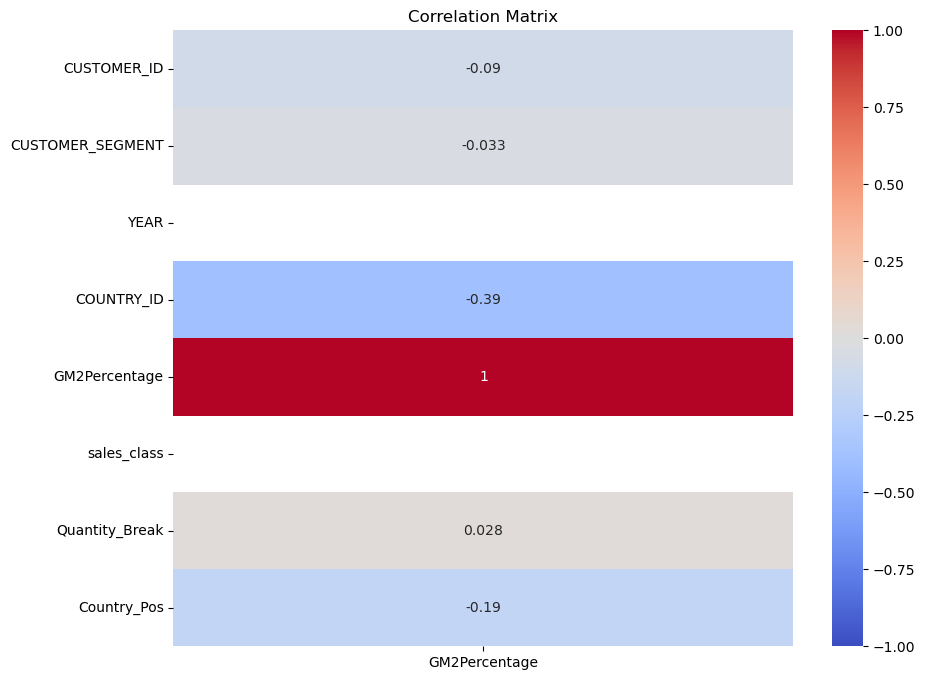

In [24]:
# Step 1: Group by 'PRODUCT_ID' and calculate mean for each parameter
grouped = dataAllDone.groupby('PRODUCT_ID').median()

# Step 2: Calculate the correlation matrix for the grouped data
correlation_matrix = grouped.corr()

# Step 3: Focus on the correlation of all parameters with GM2Percentage
gm2_correlation = correlation_matrix[['GM2Percentage']]

# Display the results
print("Correlation matrix:\n", correlation_matrix)
print("\nCorrelation of parameters with GM2Percentage:\n", gm2_correlation)
plt.figure(figsize=(10, 8))
sns.heatmap(gm2_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Correlation with GM2Percentage after grouping by PRODUCT_ID:
                   GM2Percentage
CUSTOMER_ID           -0.090096
CUSTOMER_SEGMENT      -0.032583
YEAR                        NaN
COUNTRY_ID            -0.386053
GM2Percentage          1.000000
sales_class                 NaN
Quantity_Break         0.027999
Country_Pos           -0.186273

Correlation with GM2Percentage after grouping by PRODUCT_ID and CUSTOMER_ID:
                   GM2Percentage
CUSTOMER_SEGMENT       0.048833
YEAR                  -0.034681
COUNTRY_ID             0.040484
GM2Percentage          1.000000
sales_class            0.055070
Quantity_Break        -0.267959
Country_Pos            0.061449

Correlation with GM2Percentage after grouping by PRODUCT_ID, CUSTOMER_ID, and COUNTRY_ID:
                   GM2Percentage
CUSTOMER_SEGMENT       0.048633
YEAR                  -0.034664
GM2Percentage          1.000000
sales_class            0.055385
Quantity_Break        -0.268100
Country_Pos            0.061766

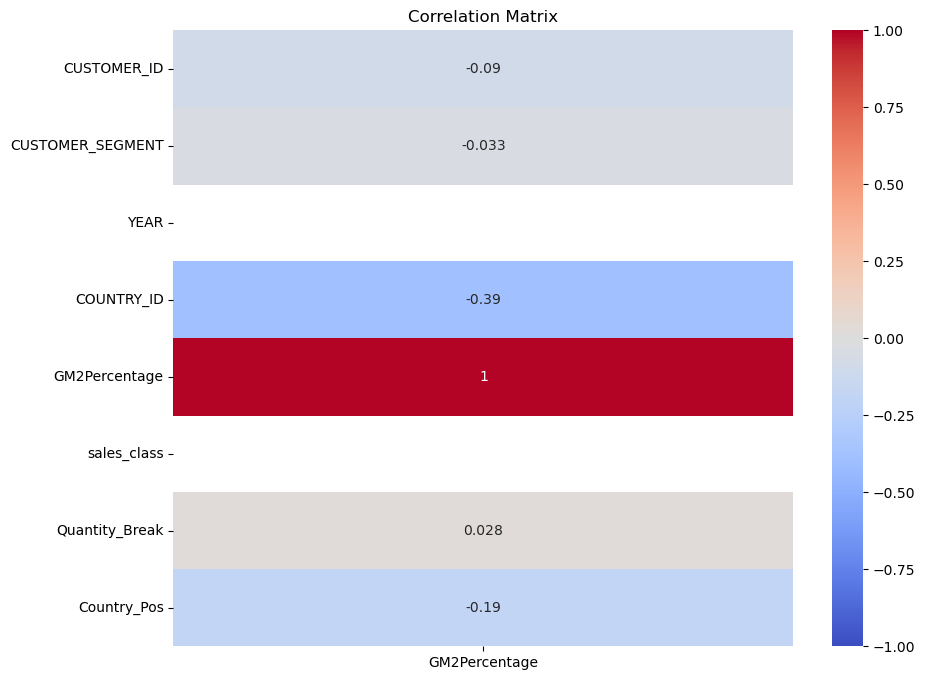

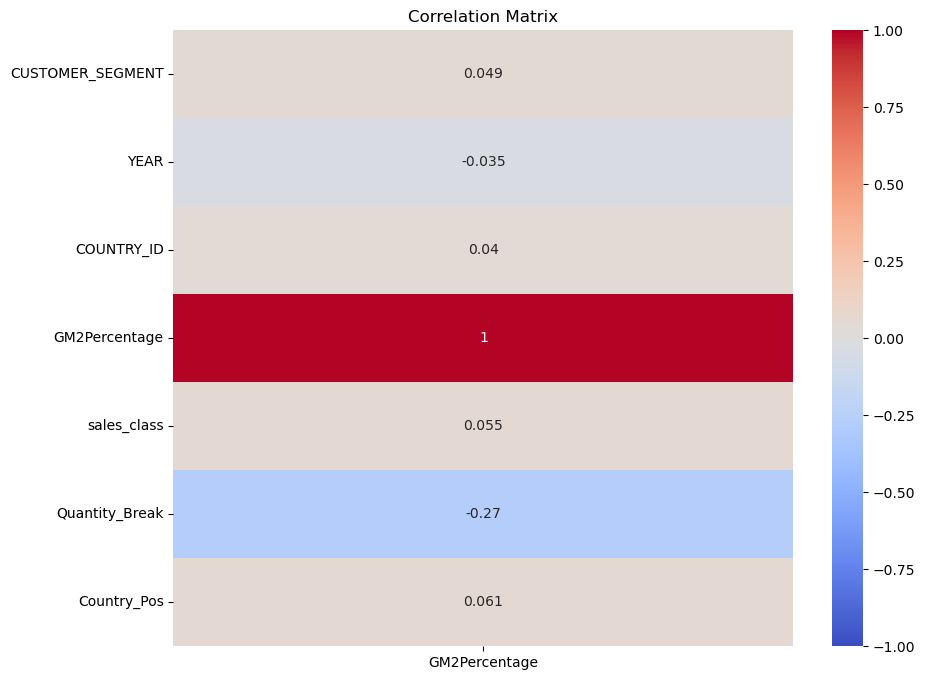

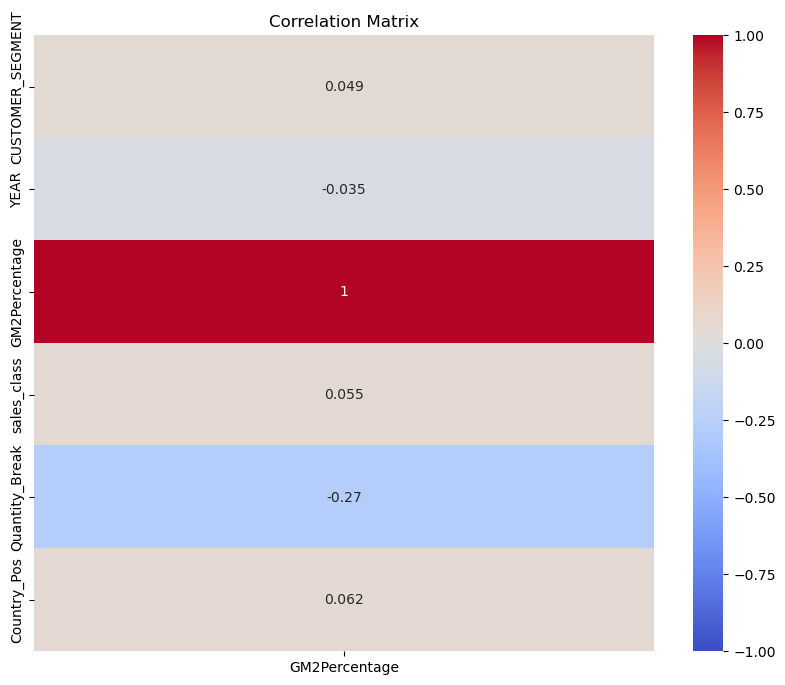

In [25]:
# Step 1: Group by 'PRODUCT_ID' and calculate mean for each parameter
grouped_by_product = dataAllDone.groupby('PRODUCT_ID').median()

# Calculate the correlation matrix for grouped data by 'PRODUCT_ID'
correlation_matrix_product = grouped_by_product.corr()

# Focus on the correlation of all parameters with GM2Percentage
gm2_correlation_product = correlation_matrix_product[['GM2Percentage']]

# Step 2: Group by 'PRODUCT_ID' and 'CUSTOMER_ID' and calculate mean
grouped_by_product_customer = dataAllDone.groupby(['PRODUCT_ID', 'CUSTOMER_ID']).median()

# Calculate the correlation matrix for grouped data by 'PRODUCT_ID' and 'CUSTOMER_ID'
correlation_matrix_product_customer = grouped_by_product_customer.corr()

# Focus on the correlation of all parameters with GM2Percentage
gm2_correlation_product_customer = correlation_matrix_product_customer[['GM2Percentage']]

# Step 3: Expand to additional groupings (e.g., 'PRODUCT_ID', 'CUSTOMER_ID', 'COUNTRY_ID')
grouped_by_product_customer_country = dataAllDone.groupby(['PRODUCT_ID', 'CUSTOMER_ID', 'COUNTRY_ID']).median()

# Calculate the correlation matrix for grouped data by 'PRODUCT_ID', 'CUSTOMER_ID', and 'COUNTRY_ID'
correlation_matrix_product_customer_country = grouped_by_product_customer_country.corr()

# Focus on the correlation of all parameters with GM2Percentage
gm2_correlation_product_customer_country = correlation_matrix_product_customer_country[['GM2Percentage']]

# Display the results
print("Correlation with GM2Percentage after grouping by PRODUCT_ID:\n", gm2_correlation_product)
print("\nCorrelation with GM2Percentage after grouping by PRODUCT_ID and CUSTOMER_ID:\n", gm2_correlation_product_customer)
print("\nCorrelation with GM2Percentage after grouping by PRODUCT_ID, CUSTOMER_ID, and COUNTRY_ID:\n", gm2_correlation_product_customer_country)
plt.figure(figsize=(10, 8))
sns.heatmap(gm2_correlation_product, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(gm2_correlation_product_customer, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(gm2_correlation_product_customer_country, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [26]:
print(dataAllDone.head(5))
# Define the conditions
product_condition = dataAllDone['PRODUCT_ID'] == 22473
#customer_condition = dataAllDone['CUSTOMER_ID'] == 16138

country_condition = dataAllDone['COUNTRY_ID'] == 107
quantity_condition = dataAllDone['Quantity_Break'] == 0

# Apply conditions
filtered_df = dataAllDone[product_condition & country_condition & quantity_condition]

# Print the filtered DataFrame
print(filtered_df)

   CUSTOMER_ID  CUSTOMER_SEGMENT  PRODUCT_ID  YEAR  COUNTRY_ID  GM2Percentage  sales_class  Quantity_Break  Country_Pos
0       200554                 0       13935     0         160          28.03            0               3           10
1        50517                 0       22288     0          55           2.56            0               5            2
2        50517                 0       22745     0          55          33.52            0               5            2
3       508113                 2       22745     0          66          33.10            2               1            4
4       634623                 2       22473     0          76          37.64            0              11            6
       CUSTOMER_ID  CUSTOMER_SEGMENT  PRODUCT_ID  YEAR  COUNTRY_ID  GM2Percentage  sales_class  Quantity_Break  Country_Pos
612         547102                 2       22473     0         107           7.22            2               0            7
680         520729              

In [27]:
#DecisionTrees
#Splitting the data
X = dataAllDone.drop(columns = ["GM2Percentage","Country_Pos", "YEAR"], axis=1)
#X = dataAllDone.drop("Country_Pos", axis=1)
print(X.head(5))
Y = dataAllDone["GM2Percentage"]
print(Y.head(5))

   CUSTOMER_ID  CUSTOMER_SEGMENT  PRODUCT_ID  COUNTRY_ID  sales_class  Quantity_Break
0       200554                 0       13935         160            0               3
1        50517                 0       22288          55            0               5
2        50517                 0       22745          55            0               5
3       508113                 2       22745          66            2               1
4       634623                 2       22473          76            0              11
0    28.03
1     2.56
2    33.52
3    33.10
4    37.64
Name: GM2Percentage, dtype: float64


In [28]:
# Define possible test sizes and parameter grid
test_sizes = [0.1, 0.2, 0.3, 0.4]
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse']
}

# Variables to store the best results
best_score = float('inf')
best_test_size = None
best_params = None
best_model = None

# Loop over different train-test splits
for test_size in test_sizes:
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    # Initialize the Decision Tree Regressor
    regressor = DecisionTreeRegressor(random_state=42)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    
    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from GridSearchCV
    best_estimator = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_estimator.predict(X_test)
    
    # Evaluate the best model using evaluators
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Test size: {test_size}, Best Parameters: {grid_search.best_params_}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    
    if mae < best_score:
        best_score = mae
        best_test_size = test_size
        best_params = grid_search.best_params_
        best_model = best_estimator

print(f"\nBest test size: {best_test_size} with MAE: {best_score:.2f}")
print(f"Best parameters: {best_params}")

Test size: 0.1, Best Parameters: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}, MSE: 303.21, RMSE: 17.41, MAE: 10.64, R²: 0.64
Test size: 0.2, Best Parameters: {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}, MSE: 323.20, RMSE: 17.98, MAE: 10.86, R²: 0.66
Test size: 0.3, Best Parameters: {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}, MSE: 350.94, RMSE: 18.73, MAE: 11.11, R²: 0.59
Test size: 0.4, Best Parameters: {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}, MSE: 348.00, RMSE: 18.65, MAE: 11.20, R²: 0.58

Best test size: 0.1 with MAE: 10.64
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [57]:
# Define possible test sizes and parameter grid
test_sizes = [0.1, 0.2, 0.3, 0.4]
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]         # Whether bootstrap samples are used when building trees
}

# Variables to store the best results
best_score = float('inf')
best_test_size = None
best_params = None
best_model = None

# Loop over different train-test splits
for test_size in test_sizes:
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    # Initialize the Random Forest Regressor
    regressor = RandomForestRegressor(random_state=42)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    
    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from GridSearchCV
    best_estimator = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_estimator.predict(X_test)
    
    # Evaluate the best model using Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Test size: {test_size}, Best Parameters: {grid_search.best_params_}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    
    # Check if this is the best model so far
    if mae < best_score:
        best_score = mae
        best_test_size = test_size
        best_params = grid_search.best_params_
        best_model = best_estimator

# Print the best results
print(f"\nBest test size: {best_test_size} with MAE: {best_score:.2f}")
print(f"Best parameters: {best_params}")

/anaconda/envs/azureml_py38/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Test size: 0.1, Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, MSE: 208.61, RMSE: 14.44, MAE: 6.77, R²: 0.67


KeyboardInterrupt: 

In [77]:
# Define possible test sizes and parameter grid
test_sizes = [0.1, 0.2, 0.3, 0.4]
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 5, 7],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'subsample': [0.8, 1.0]          # Whether bootstrap samples are used when building trees
}

# Variables to store the best results
best_score = float('inf')
best_test_size = None
best_params = None
best_model = None

# Loop over different train-test splits
for test_size in test_sizes:
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    # Initialize the Gradient Boosting Regressor
    regressor = GradientBoostingRegressor(random_state=42)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    
    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from GridSearchCV
    best_estimator = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred_test = best_estimator.predict(X_test)
    
    # Make predictions on the training set
    y_pred_train = best_estimator.predict(X_train)
    
    # Evaluate the best model using Mean Squared Error, Mean Absolute Error, and R² Score
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    print(f"Test size: {test_size}, Best Parameters: {grid_search.best_params_}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    
    # Check if this is the best model so far
    if mae < best_score:
        best_score = mae
        best_test_size = test_size
        best_params = grid_search.best_params_
        best_model = best_estimator
        best_y_pred_train = y_pred_train

# Print the best results
print(f"\nBest test size: {best_test_size} with MAE: {best_score:.2f}")
print(f"Best parameters: {best_params}")

# Display predictions on the training data for the best model
print("\nPredictions on the training data for the best model:")
print(best_y_pred_train[:10])

Test size: 0.1, Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}, MSE: 246.17, RMSE: 15.69, MAE: 11.08, R²: 0.53
Test size: 0.2, Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.8}, MSE: 306.72, RMSE: 17.51, MAE: 12.22, R²: 0.53
Test size: 0.3, Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}, MSE: 407.58, RMSE: 20.19, MAE: 13.12, R²: 0.43
Test size: 0.4, Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.8}, MSE: 458.73, RMSE: 21.42, MAE: 13.80, R²: 0.39

Best test size: 0.1 with MAE: 11.08
Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300, 'subsam

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [30]:
tree_reg = DecisionTreeRegressor(max_depth = None, criterion= 'friedman_mse', min_samples_leaf=1, min_samples_split=10)
tree_reg.fit(X_train, Y_train)

train_predictions = tree_reg.predict(X_train)
test_predictions = tree_reg.predict(X_test)


train_rmse = sqrt(mean_squared_error(Y_train, train_predictions))
test_rmse = sqrt(mean_squared_error(Y_test, test_predictions))
train_mae = mean_absolute_error(Y_train, train_predictions)
test_mae = mean_absolute_error(Y_test, test_predictions)
train_r2 = r2_score(Y_train, train_predictions)
test_r2 = r2_score(Y_test, test_predictions)
print('Train R2: %.3f, Test R2: %.3f' % (train_r2, test_r2))
print('Train RMSE: %.3f, Test RMSE: %.3f' % (train_rmse, test_rmse))
print('Train MAE: %.3f, Test MAE: %.3f' % (train_mae, test_mae))

Train R2: 0.764, Test R2: 0.569
Train RMSE: 13.739, Test RMSE: 18.963
Train MAE: 7.640, Test MAE: 10.970


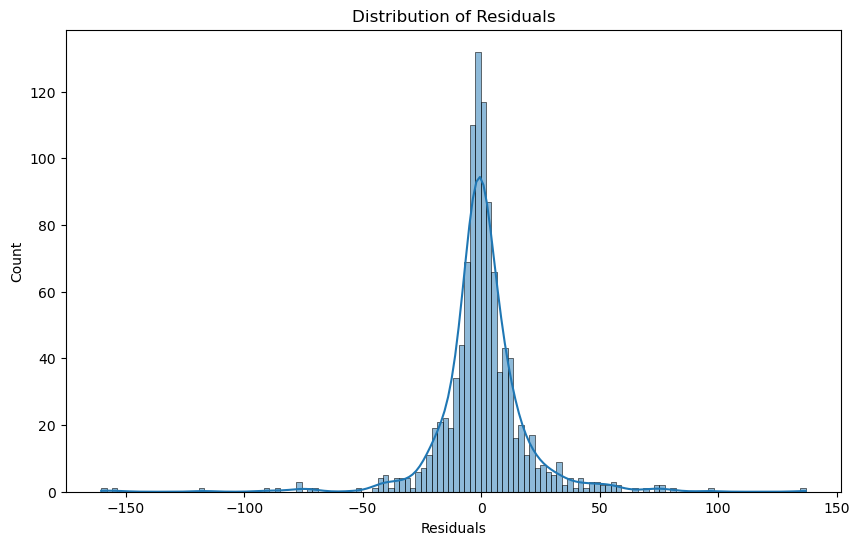

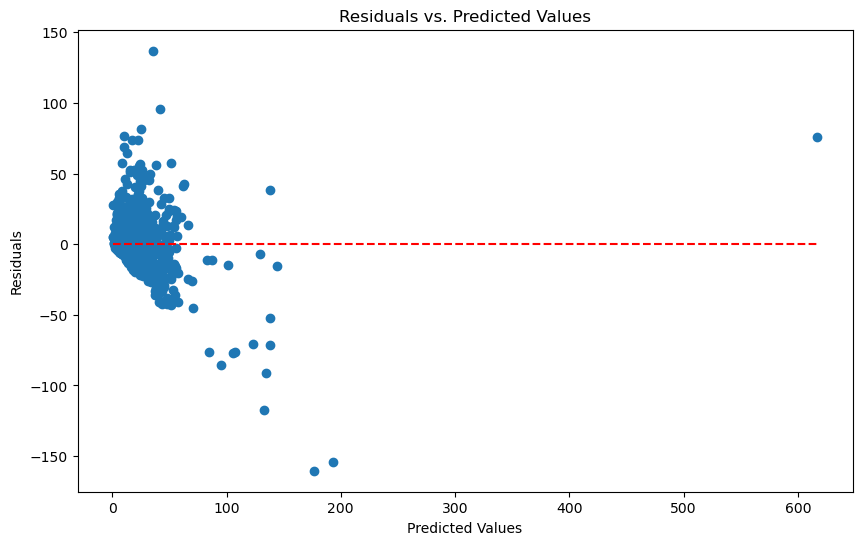

In [31]:
residuals = Y_test - test_predictions

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, residuals)
plt.hlines(y=0, xmin=min(test_predictions), xmax=max(test_predictions), colors='r', linestyles='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [32]:
print(dataAllDone.describe())
feature_names = X.columns
print(feature_names)
plt.figure(figsize=(20, 10))
#plot_tree(tree_reg, filled=True, feature_names=feature_names)
#plot_tree(tree_reg, filled=True, feature_names=feature_names, max_depth=3)
plt.show()

         CUSTOMER_ID  CUSTOMER_SEGMENT     PRODUCT_ID          YEAR    COUNTRY_ID  GM2Percentage   sales_class  Quantity_Break   Country_Pos
count   10527.000000      10527.000000   10527.000000  10527.000000  10527.000000   10527.000000  10527.000000    10527.000000  10527.000000
mean   385044.220101          0.977296   23047.322504      1.139166     96.629334      20.596023      0.535385        7.551344      6.180773
std    257822.242941          0.957265   19547.436159      1.065725     40.932887      28.337939      0.864382        4.085840      3.169375
min       554.000000          0.000000    2945.000000      0.000000     17.000000       0.010000      0.000000        0.000000      0.000000
25%     50826.500000          0.000000   22288.000000      0.000000     66.000000       7.105000      0.000000        5.000000      4.000000
50%    508080.000000          1.000000   22473.000000      1.000000     76.000000      13.230000      0.000000        9.000000      6.000000
75%    549385

<Figure size 2000x1000 with 0 Axes>

In [33]:
#Using Random Forest model
modelAllYear = RandomForestRegressor(n_estimators=300, random_state=42, max_depth = 20, min_samples_leaf=1,min_samples_split=2)
modelAfter2020 = RandomForestRegressor(n_estimators=300, random_state=42, max_depth = 10, min_samples_leaf=1, min_samples_split=2)
modelAllYear.fit(X_train, Y_train)
train_predictions = modelAllYear.predict(X_train)
test_predictions = modelAllYear.predict(X_test)

train_rmse = sqrt(mean_squared_error(Y_train, train_predictions))
test_rmse = sqrt(mean_squared_error(Y_test, test_predictions))
train_mae = mean_absolute_error(Y_train, train_predictions)
test_mae = mean_absolute_error(Y_test, test_predictions)
train_r2 = r2_score(Y_train, train_predictions)
test_r2 = r2_score(Y_test, test_predictions)

# print(f"Train Mean Absolute Error: {train_mae}")
# print(f"Test Mean Absolute Error: {test_mae}")
print('Train R2: %.3f, Test R2: %.3f' % (train_r2, test_r2))
print('Train RMSE: %.3f, Test RMSE: %.3f' % (train_rmse, test_rmse))
print('Train MAE: %.3f, Test MAE: %.3f' % (train_mae, test_mae))

Train R2: 0.808, Test R2: 0.644
Train RMSE: 12.401, Test RMSE: 17.221
Train MAE: 7.180, Test MAE: 10.310


Residuals with Percentages:
     Residual  Count  Percentage
0      -166.0      1    0.094967
1      -135.0      1    0.094967
2       -79.0      1    0.094967
3       -76.0      2    0.189934
4       -65.0      1    0.094967
5       -59.0      1    0.094967
6       -55.0      2    0.189934
7       -45.0      1    0.094967
8       -44.0      1    0.094967
9       -43.0      1    0.094967
10      -41.0      1    0.094967
11      -40.0      1    0.094967
12      -39.0      1    0.094967
13      -36.0      4    0.379867
14      -35.0      3    0.284900
15      -33.0      1    0.094967
16      -32.0      2    0.189934
17      -31.0      1    0.094967
18      -30.0      5    0.474834
19      -29.0      2    0.189934
20      -28.0      1    0.094967
21      -27.0      1    0.094967
22      -26.0      3    0.284900
23      -25.0      4    0.379867
24      -24.0      1    0.094967
25      -23.0      3    0.284900
26      -22.0      3    0.284900
27      -21.0      5    0.474834
28      -20.0  

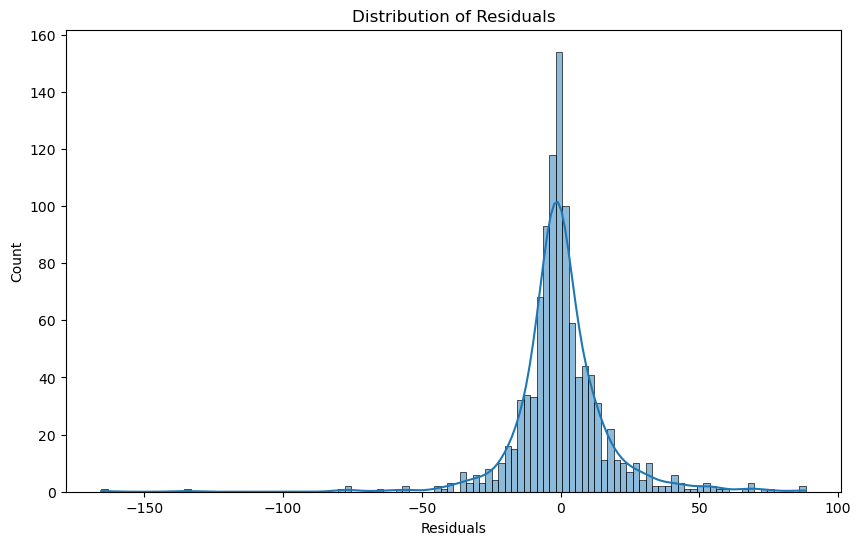

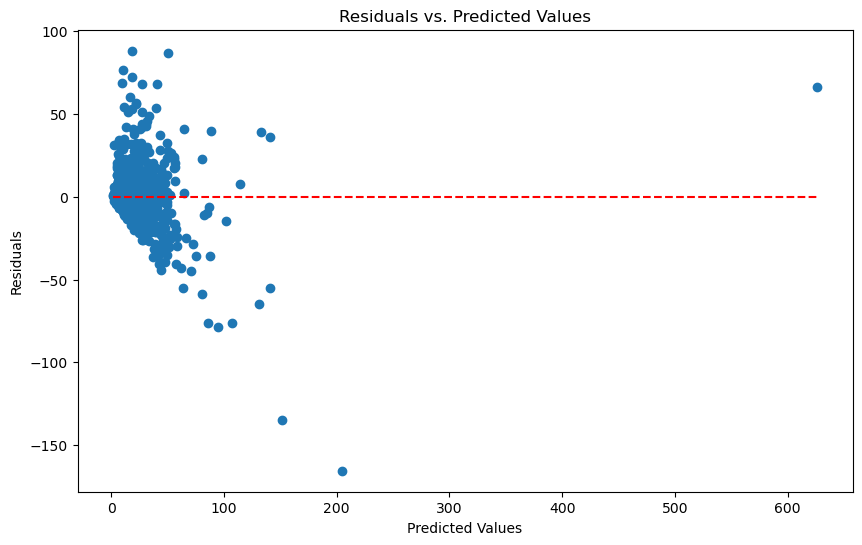

In [34]:
residuals = Y_test - test_predictions
residuals_rounded = np.round(residuals)

# Count the number of residuals (rounded to whole numbers)
residual_counts = np.unique(residuals_rounded, return_counts=True)
residual_value_counts = dict(zip(residual_counts[0], residual_counts[1]))

# Convert the dictionary to a DataFrame
residuals_df = pd.DataFrame(list(residual_value_counts.items()), columns=['Residual', 'Count'])

# Calculate the total number of residuals
total_residuals = residuals_df['Count'].sum()

# Calculate the percentage of each count value
residuals_df['Percentage'] = (residuals_df['Count'] / total_residuals) * 100

# Sort by percentage to identify the top 10
top_10_residuals_df = residuals_df.sort_values(by='Percentage', ascending=False).head(10)

# Display the DataFrame with percentages and the top 10
print("Residuals with Percentages:")
print(residuals_df)
print("\nTop 10 Residuals by Percentage:")
print(top_10_residuals_df)
# Display the counts of each unique residual value
print("Count of Residuals (rounded to whole numbers):")
for residual, count in residual_value_counts.items():
    print(f"Residual: {int(residual)}, Count: {count}")
# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, residuals)
plt.hlines(y=0, xmin=min(test_predictions), xmax=max(test_predictions), colors='r', linestyles='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Index(['CUSTOMER_ID', 'CUSTOMER_SEGMENT', 'PRODUCT_ID', 'COUNTRY_ID',
       'sales_class', 'Quantity_Break'],
      dtype='object')


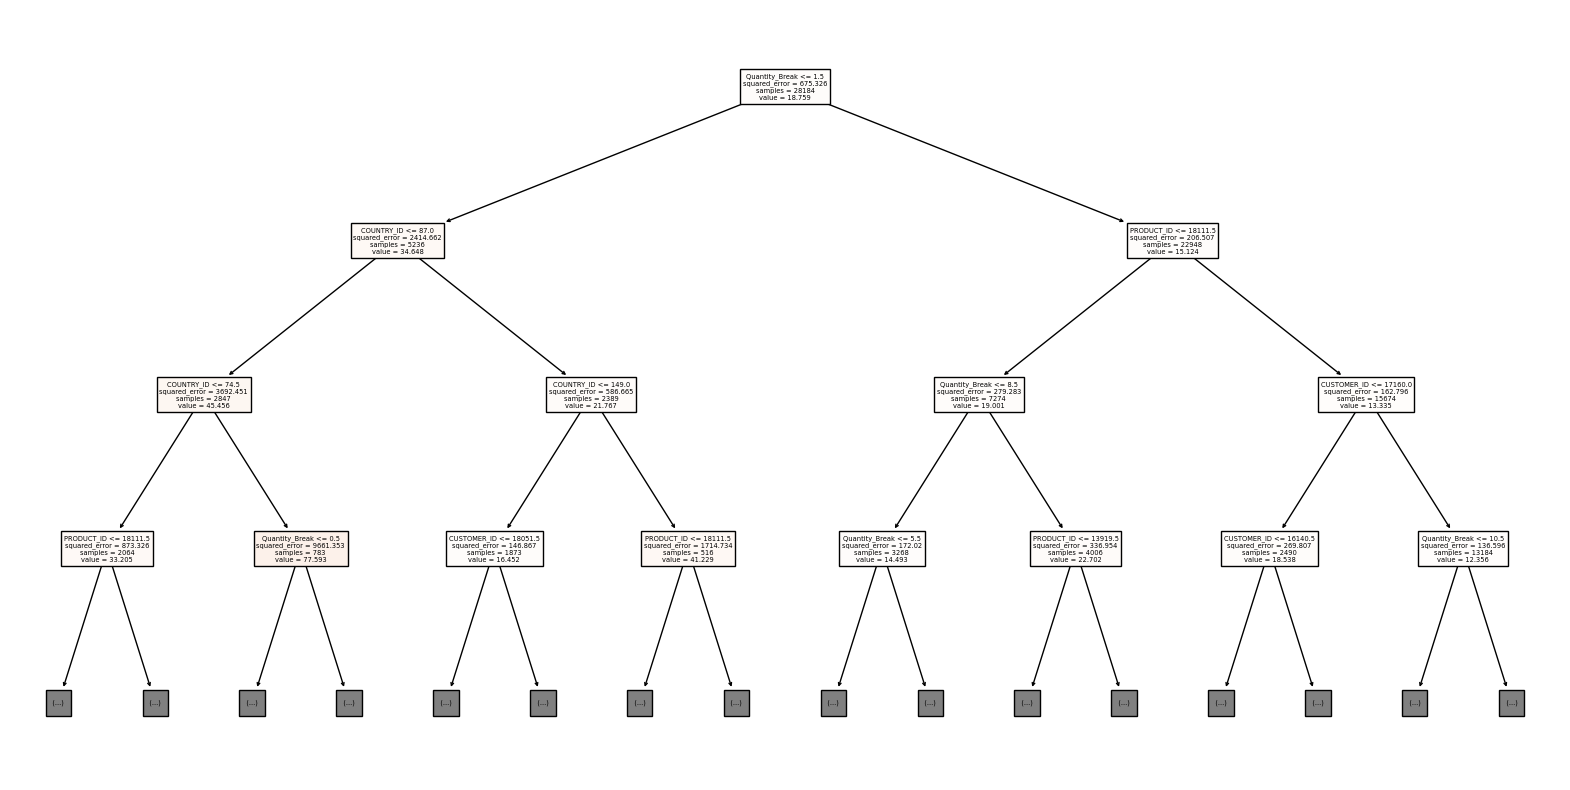

In [72]:
feature_names = X.columns
print(feature_names)
plt.figure(figsize=(20, 10))
#plot_tree(tree_reg, filled=True, feature_names=feature_names)
plot_tree(modelAllYear.estimators_[0], filled=True, feature_names=feature_names, max_depth=3)
plt.show()

In [35]:
#Using gradient boost model
gbr = GradientBoostingRegressor(n_estimators=300, random_state=42, learning_rate = 0.01, max_depth = 7, min_samples_leaf=1, min_samples_split=10, subsample=1)

# Train the regressor with the training data
gbr.fit(X_train, Y_train)
train_predictions = gbr.predict(X_train)
test_predictions = gbr.predict(X_test)
# Make predictions on the test set
Y_pred = gbr.predict(X_test)

# Evaluate the model
train_rmse = sqrt(mean_squared_error(Y_train, train_predictions))
test_rmse = sqrt(mean_squared_error(Y_test, test_predictions))
train_mae = mean_absolute_error(Y_train, train_predictions)
test_mae = mean_absolute_error(Y_test, test_predictions)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print('Train MAE: %.3f, Test MAE: %.3f' % (train_mae, test_mae))

Mean Squared Error: 269.83
R^2 Score: 0.68
Train MAE: 9.606, Test MAE: 10.357


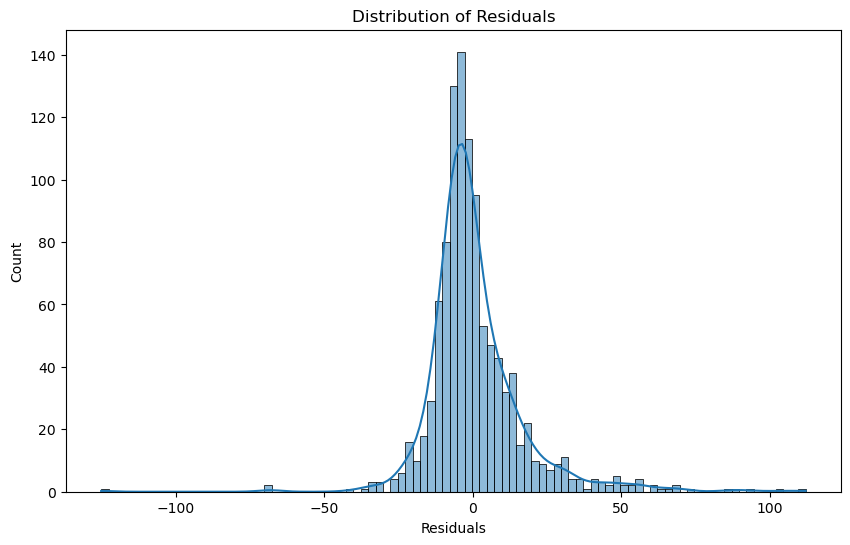

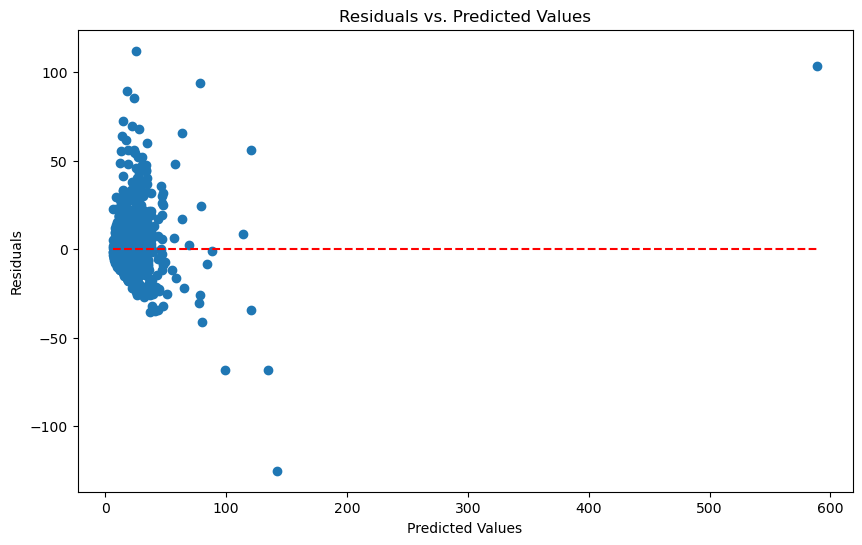

In [36]:
residuals = Y_test - test_predictions

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, residuals)
plt.hlines(y=0, xmin=min(test_predictions), xmax=max(test_predictions), colors='r', linestyles='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [37]:
dataAllDone.sort_values(by='YEAR', ascending=True, inplace=False).head(10)

CUSTOMER_ID  CUSTOMER_SEGMENT  PRODUCT_ID  YEAR  COUNTRY_ID  GM2Percentage  sales_class  Quantity_Break  Country_Pos
0          200554                 0       13935     0         160          28.03            0               3           10
2593       503797                 0       13904     0          41          16.57            0               8            1
2594        51129                 2       23161     0          55          14.81            0              11            2
2595        17951                 1       22473     0         107          10.87            0               9            7
2596       563410                 0       13935     0          76          14.85            0              10            6
2597       634781                 1       22288     0          55          18.40            2              11            2
2598       656464                 0       23161     0         174          38.11            0              11           12
2599         4704                 2       22288     0          55          11.98            0              11            2
2600       538927                 0       13935     0         107          16.00            0               9            7
2601       200779                 0       13935     0         160          46.36            0              11           10

In [38]:
grouped_df = dataAllDone.groupby(['PRODUCT_ID', 'CUSTOMER_ID', 'Quantity_Break', 'COUNTRY_ID', 'CUSTOMER_SEGMENT'])['GM2Percentage'].last().reset_index()
def predict_gm2_percentage(modelAfter2020, product_id, customer_id, quantity, country_id, customer_segment_id):
    # Create a DataFrame for the specific input
    input_data = pd.DataFrame({
        'PRODUCT_ID': [product_id],
        'CUSTOMER_ID': [customer_id],
        'Quantity_Break': [quantity],
        'COUNTRY_ID': [country_id],
        'CUSTOMER_SEGMENT': [customer_segment_id]
    })
    prediction = modelAfter2020.predict(input_data)
    matched_record = grouped_df.loc[
        (grouped_df['PRODUCT_ID'] == product_id) &
        (grouped_df['CUSTOMER_ID'] == customer_id) &
        (grouped_df['Quantity_Break'] == quantity) &
        (grouped_df['COUNTRY_ID'] == country_id) &
        (grouped_df['CUSTOMER_SEGMENT'] == customer_segment_id),
        'GM2Percentage'
    ]
    if not matched_record.empty:
        last_value = matched_record.iloc[0]
        error = abs(prediction[0] - last_value)
        print(f'Predicted GM2Percentage: {prediction[0]}')
        print(f'Last known GM2Percentage: {last_value}')
        print(f'Error: {error}')
        return prediction[0], last_value, error
    else:
        print(f'No matching record found. Predicted GM2Percentage: {prediction[0]}')
        return prediction[0], None, None
    print(f'Mean Absolute Error (MAE): {test_mae}')
    print(f'Root Mean Squared Error (RMSE): {test_rmse}')
    print(f'R-squared (R2): {test_r2}')
    return prediction[0], error
    #return prediction[0]
product_id = 22473
#customer_id = 502756
customer_id = 514598
quantity = 8
country_id = 55
customer_segment_id = 0
#gm2_percentage, actual_mean, error = predict_gm2_percentage(model, product_id, customer_id, quantity, country_id, customer_segment_id)
#print(f'Predicted gm2Percentage: {gm2_percentage}, {actual_mean}, {error}')
gm2_percentage = predict_gm2_percentage(modelAfter2020, product_id, customer_id, quantity, country_id, customer_segment_id)
print(f'Predicted gm2Percentage: {gm2_percentage}')

/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- YEAR
- sales_class

  warnings.warn(message, FutureWarning)


ValueError: X has 5 features, but RandomForestRegressor is expecting 7 features as input.

Number of special cases with 5 or more repetitions: 0
Empty DataFrame
Columns: [PRODUCT_ID, CUSTOMER_ID, Quantity_Break, COUNTRY_ID, CUSTOMER_SEGMENT, sales_class, count]
Index: []


/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: Fu

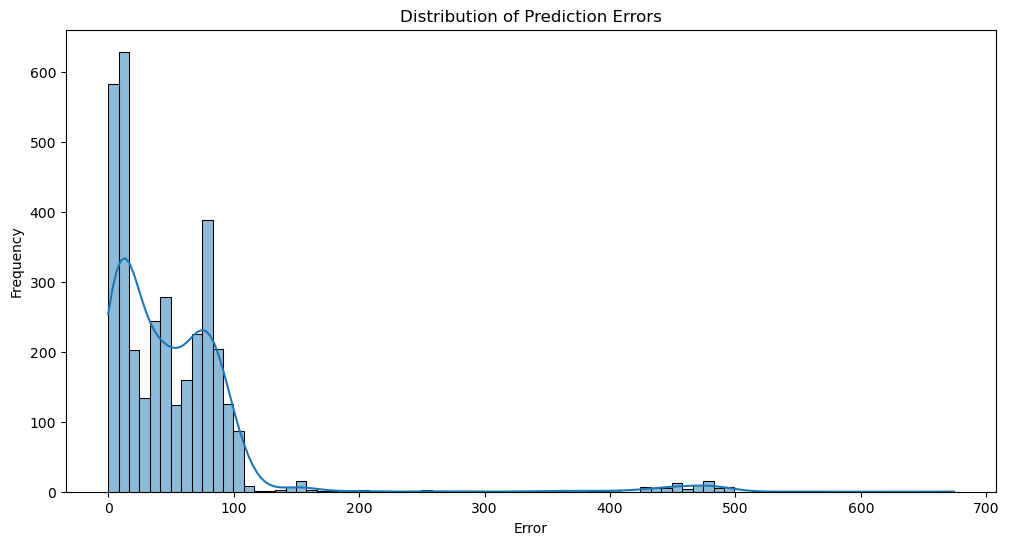

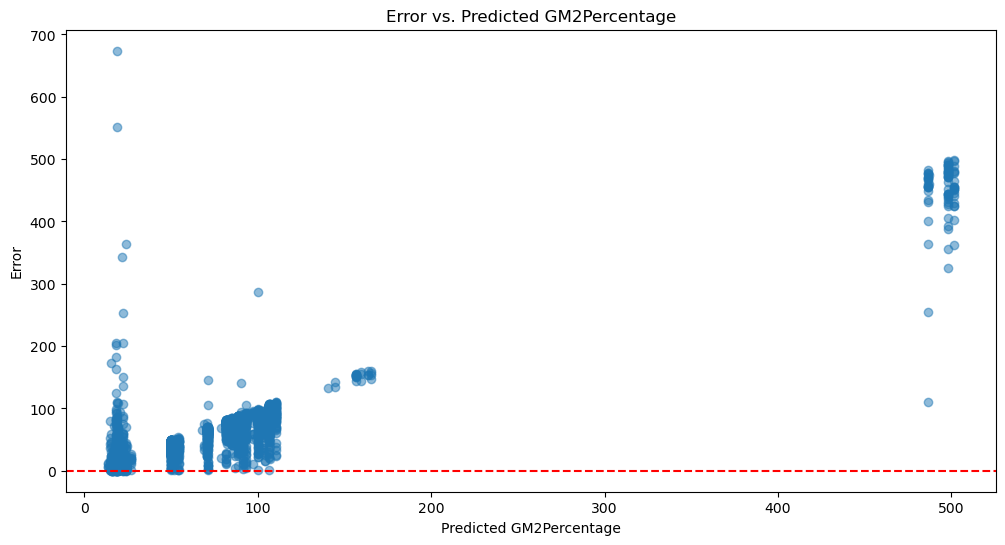

In [38]:
grouped_df = dataAllDone.groupby(['PRODUCT_ID', 'CUSTOMER_ID', 'Quantity_Break', 'COUNTRY_ID', 'CUSTOMER_SEGMENT', 'sales_class'])['GM2Percentage'].last().reset_index()
special_cases_counts = grouped_df.groupby(['PRODUCT_ID', 'CUSTOMER_ID', 'Quantity_Break', 'COUNTRY_ID', 'CUSTOMER_SEGMENT', 'sales_class']).size().reset_index(name='count')

# Filter for cases that occur 5 or more times
special_cases_repeats = special_cases_counts[special_cases_counts['count'] >= 2]

# Display the special cases with 5 or more repetitions
print(f"Number of special cases with 5 or more repetitions: {len(special_cases_repeats)}")
print(special_cases_repeats)
def predict_gm2_percentage(gbr, product_id, customer_id, quantity, country_id, customer_segment_id, sales_class):
    # Create a DataFrame for the specific input
    input_data = pd.DataFrame({
        'PRODUCT_ID': [product_id],
        'CUSTOMER_ID': [customer_id],
        'Quantity_Break': [quantity],
        'COUNTRY_ID': [country_id],
        'CUSTOMER_SEGMENT': [customer_segment_id],
        #'YEAR': [year],
        'sales_class' : [sales_class]
    })
    prediction = gbr.predict(input_data)
    matched_record = grouped_df.loc[
        (grouped_df['PRODUCT_ID'] == product_id) &
        (grouped_df['CUSTOMER_ID'] == customer_id) &
        (grouped_df['Quantity_Break'] == quantity) &
        (grouped_df['COUNTRY_ID'] == country_id) &
        #(grouped_df['YEAR'] == year) &
        (grouped_df['CUSTOMER_SEGMENT'] == customer_segment_id) &
        (grouped_df['sales_class'] == sales_class),
        'GM2Percentage'
    ]
    
    if not matched_record.empty:
        last_value = matched_record.iloc[0]
        error = abs(prediction[0] - last_value)
        #print(f'Predicted GM2Percentage: {prediction[0]}')
        #print(f'Last known GM2Percentage: {last_value}')
        #print(f'Error: {error}')
        return prediction[0], last_value, error
    else:
        #print(f'No matching record found. Predicted GM2Percentage: {prediction[0]}')
        return prediction[0], None, None
    
results= []
# Loop through each row in the grouped_df
for index, row in grouped_df.iterrows():
    product_id = row['PRODUCT_ID']
    customer_id = row['CUSTOMER_ID']
    quantity = row['Quantity_Break']
    country_id = row['COUNTRY_ID']
    customer_segment_id = row['CUSTOMER_SEGMENT']
    sales_class = row['sales_class']
    #year= row['YEAR']
    
    # Call the prediction function for each combination
    gm2_percentage, last_value, error = predict_gm2_percentage(gbr, product_id, customer_id, quantity, country_id, customer_segment_id, sales_class)
    count = 0
    '''if error is not None and error < 5:
            count += 1
            # Print the result for each combination where the error is less than 5
            print(f'For PRODUCT_ID: {product_id}, CUSTOMER_ID: {customer_id}, Quantity_Break: {quantity}, COUNTRY_ID: {country_id}, CUSTOMER_SEGMENT: {customer_segment_id}')
            print(f'Predicted GM2Percentage: {gm2_percentage}, Last GM2Percentage: {last_value}, Error: {error}')
            print('-' * 50)'''
    if last_value is not None:
        results.append({
            'PRODUCT_ID': product_id,
            'CUSTOMER_ID': customer_id,
            'Quantity_Break': quantity,
            'COUNTRY_ID': country_id,
            'CUSTOMER_SEGMENT': customer_segment_id,
            'sales_class': sales_class,
            #'YEAR': year,
            'Predicted GM2Percentage': gm2_percentage,
            'Last GM2Percentage': last_value,
            'Error': error
        })

# Convert the results list to a DataFrame for visualization
results_df = pd.DataFrame(results)

# Visualize the distribution of errors
plt.figure(figsize=(12, 6))
sns.histplot(results_df['Error'], kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of predicted GM2Percentage vs. error
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Predicted GM2Percentage'], results_df['Error'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Error vs. Predicted GM2Percentage')
plt.xlabel('Predicted GM2Percentage')
plt.ylabel('Error')
plt.show()

0     28.03
1      2.56
5      5.22
7     57.15
9     12.43
10     5.52
13    12.25
14    41.84
17     4.11
18    19.74
Name: GM2Percentage, dtype: float64
CUSTOMER_ID: 1828.0, PRODUCT_ID: 2945.0, Quantity_Break: 8.0
Predicted GM2Percentage: 150.734393946609
Last GM2Percentage: 6.84
Error (Rounded): 144
--------------------------------------------------
CUSTOMER_ID: 1989.0, PRODUCT_ID: 2945.0, Quantity_Break: 1.0
Predicted GM2Percentage: 68.54327333333329
Last GM2Percentage: 40.13
Error (Rounded): 28
--------------------------------------------------
CUSTOMER_ID: 1989.0, PRODUCT_ID: 2945.0, Quantity_Break: 5.0
Predicted GM2Percentage: 68.54327333333329
Last GM2Percentage: 30.58
Error (Rounded): 38
--------------------------------------------------
CUSTOMER_ID: 1989.0, PRODUCT_ID: 2945.0, Quantity_Break: 11.0
Predicted GM2Percentage: 68.54327333333329
Last GM2Percentage: 15.62
Error (Rounded): 53
--------------------------------------------------
CUSTOMER_ID: 12202.0, PRODUCT_ID: 2945.0

/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: Fu

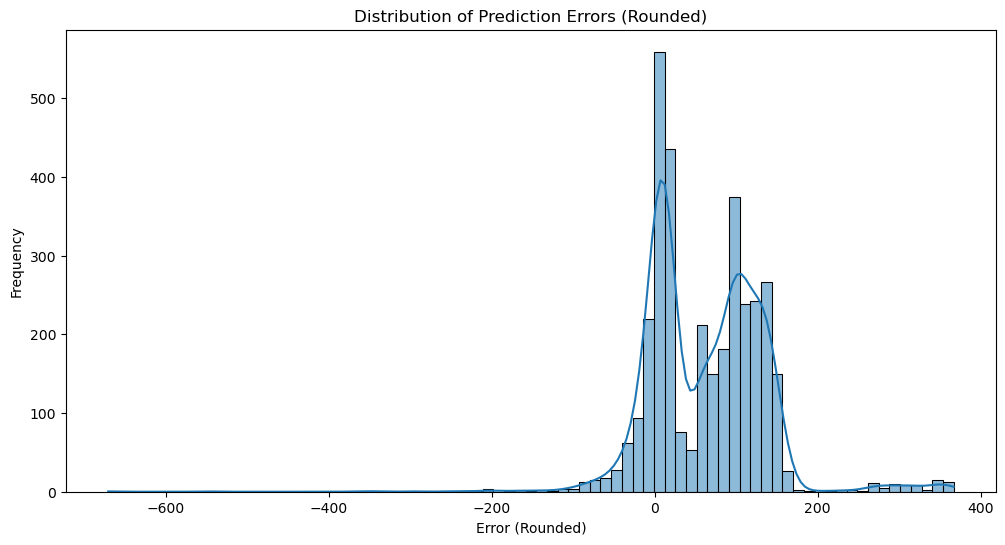

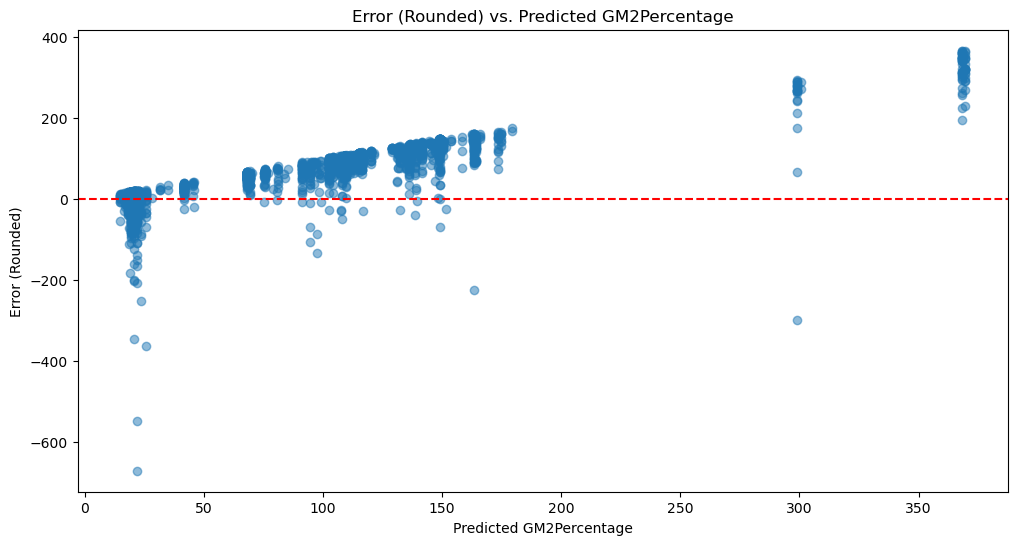

/tmp/ipykernel_3638/704510388.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Error', y='Percentage', data=error_percentage_df, palette='Blues_d')


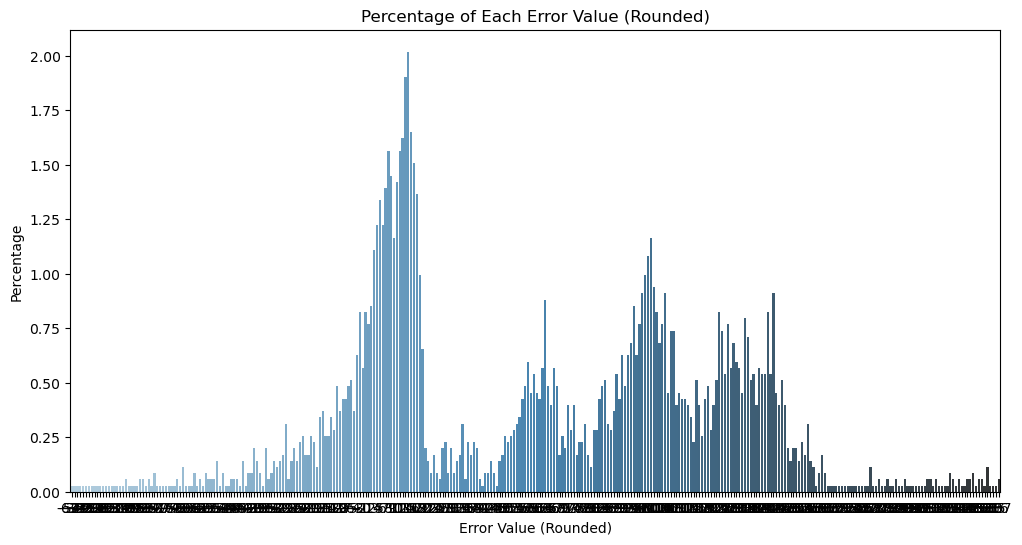

In [39]:
grouped_df = dataAllDone.groupby(['PRODUCT_ID', 'CUSTOMER_ID', 'Quantity_Break', 'COUNTRY_ID', 'CUSTOMER_SEGMENT', 'sales_class'])['GM2Percentage'].last().reset_index()
grouped_df2 = dataAllDone.groupby(['PRODUCT_ID', 'CUSTOMER_ID', 'Quantity_Break', 'COUNTRY_ID', 'CUSTOMER_SEGMENT', 'sales_class'])['GM2Percentage'].filter(lambda x: len(x) >= 5)
print(grouped_df2.head(10))
def predict_gm2_percentage(modelAllYear, product_id, customer_id, quantity, country_id, customer_segment_id, sales_class):
    # Create a DataFrame for the specific input
    input_data = pd.DataFrame({
        'PRODUCT_ID': [product_id],
        'CUSTOMER_ID': [customer_id],
        'Quantity_Break': [quantity],
        'COUNTRY_ID': [country_id],
        'CUSTOMER_SEGMENT': [customer_segment_id],
        #'YEAR': [year],
        'sales_class' : [sales_class]
    })
    # Make the prediction
    prediction = modelAllYear.predict(input_data)
    
    # Find the last known GM2Percentage from grouped_df
    matched_record = grouped_df.loc[
        (grouped_df['PRODUCT_ID'] == product_id) &
        (grouped_df['CUSTOMER_ID'] == customer_id) &
        (grouped_df['Quantity_Break'] == quantity) &
        (grouped_df['COUNTRY_ID'] == country_id) &
        #(grouped_df['YEAR'] == year) &
        (grouped_df['CUSTOMER_SEGMENT'] == customer_segment_id) &
        (grouped_df['sales_class'] == sales_class),
        'GM2Percentage'
    ]
    
    # If a matching record is found, calculate the error
    if not matched_record.empty:
        last_value = matched_record.iloc[-1]
        error = prediction[0] - last_value
        return prediction[0], last_value, error
    else:
        # If no matching record is found, return None for last_value and error
        return prediction[0], None, None

# Store results
results = []

# Loop through each row in the grouped_df
for index, row in grouped_df.iterrows():
    product_id = row['PRODUCT_ID']
    customer_id = row['CUSTOMER_ID']
    quantity = row['Quantity_Break']
    country_id = row['COUNTRY_ID']
    customer_segment_id = row['CUSTOMER_SEGMENT']
    sales_class = row['sales_class']
    #year = row['YEAR']
    
    # Call the prediction function for each combination
    gm2_percentage, last_value, error = predict_gm2_percentage(modelAllYear, product_id, customer_id, quantity, country_id, customer_segment_id, sales_class)
    
    # Store all results (error doesn't need to be less than 5)
    if last_value is not None:
        # Print relevant information
        print(f"CUSTOMER_ID: {customer_id}, PRODUCT_ID: {product_id}, Quantity_Break: {quantity}")
        print(f"Predicted GM2Percentage: {gm2_percentage}")
        print(f"Last GM2Percentage: {last_value}")
        print(f"Error (Rounded): {round(error)}")
        print("-" * 50)  # Separator for readability
        
        results.append({
            'PRODUCT_ID': product_id,
            'CUSTOMER_ID': customer_id,
            'Quantity_Break': quantity,
            'COUNTRY_ID': country_id,
            #'YEAR': year,
            'CUSTOMER_SEGMENT': customer_segment_id,
            'sales_class': sales_class,
            'Predicted GM2Percentage': gm2_percentage,
            'Last GM2Percentage': last_value,
            'Error': round(error)  # Round the error
        })

# Convert the results list to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Calculate percentage of each unique error value
error_counts = results_df['Error'].value_counts()
total_errors = len(results_df)

# Create a new DataFrame for error percentages
error_percentage_df = pd.DataFrame({
    'Error': error_counts.index,
    'Count': error_counts.values,
    'Percentage': (error_counts.values / total_errors) * 100
})

top_10_errors_df = error_percentage_df.sort_values(by='Count', ascending=False).head(10)

# Display the top 10 errors DataFrame
print("Top 10 Errors by Count:")
print(top_10_errors_df)

# Display the DataFrame with error percentages
print("Results DataFrame with Error Percentages:")
print(error_percentage_df)

# Visualize the distribution of errors
plt.figure(figsize=(12, 6))
sns.histplot(results_df['Error'], kde=True)
plt.title('Distribution of Prediction Errors (Rounded)')
plt.xlabel('Error (Rounded)')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of predicted GM2Percentage vs. error
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Predicted GM2Percentage'], results_df['Error'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Error (Rounded) vs. Predicted GM2Percentage')
plt.xlabel('Predicted GM2Percentage')
plt.ylabel('Error (Rounded)')
plt.show()

# Visualize error percentages using the new DataFrame
plt.figure(figsize=(12, 6))
sns.barplot(x='Error', y='Percentage', data=error_percentage_df, palette='Blues_d')
plt.title('Percentage of Each Error Value (Rounded)')
plt.xlabel('Error Value (Rounded)')
plt.ylabel('Percentage')
plt.show()

In [39]:
# Assuming `grouped_df` and `model` are already defined
grouped_df = dataAllDone.groupby(['PRODUCT_ID', 'CUSTOMER_ID', 'Quantity_Break', 'COUNTRY_ID', 'CUSTOMER_SEGMENT', 'sales_class', 'YEAR'])['GM2Percentage'].last().reset_index()

def predict_gm2_percentage(modelAfter2020, product_id, customer_id, quantity, country_id, customer_segment_id, sales_class, year):
    # Create a DataFrame for the specific input
    input_data = pd.DataFrame({
        'PRODUCT_ID': [product_id],
        'CUSTOMER_ID': [customer_id],
        'Quantity_Break': [quantity],
        'COUNTRY_ID': [country_id],
        'CUSTOMER_SEGMENT': [customer_segment_id],
        'YEAR': [year],
        'sales_class': [sales_class]
    })
    # Predict GM2Percentage
    prediction = modelAfter2020.predict(input_data)
    
    return prediction[0]

# Lists to store predictions and actual values
predictions = []
actual_values = []

# Loop through each row in the grouped_df
for index, row in grouped_df.iterrows():
    product_id = row['PRODUCT_ID']
    customer_id = row['CUSTOMER_ID']
    quantity = row['Quantity_Break']
    country_id = row['COUNTRY_ID']
    customer_segment_id = row['CUSTOMER_SEGMENT']
    sales_class = row['sales_class']
    year = row['YEAR']
    actual_gm2_percentage = row['GM2Percentage']
    
    # Call the prediction function for each combination
    predicted_gm2_percentage = predict_gm2_percentage(modelAfter2020, product_id, customer_id, quantity, country_id, customer_segment_id, sales_class, year)
    
    # Append the predictions and actual values to the lists
    predictions.append(predicted_gm2_percentage)
    actual_values.append(actual_gm2_percentage)

# Calculate evaluation metrics for all the cases together
mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)

# Print the overall evaluation metrics
print(f'MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}')

/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/base.py:493: Fu

MAE: 62.98, MSE: 5685.58, R²: -4.85
